In [1]:
import jax.numpy as jnp
import jax.random as jr
import flax.linen as nn
import jax.tree_util as tu
import jax
import optax
from tqdm import tqdm
from functools import partial
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [2]:
import bfn.continuous.loss_and_sample as las
import bfn.continuous.training as training
import bfn.continuous.models as models

In [3]:
reference = jnp.array([0.2, 0.4, 0.6, 0.8, 1.0])
d = reference.shape[-1]
sigma_1 = 0.02

samples = 1000
error = 0.02
epsilons = jr.normal(jr.PRNGKey(0), (samples, d))
corrupted_references = reference + error * epsilons
corrupted_references = jnp.clip(corrupted_references, -1.0, 1.0)

In [4]:
model = models.ContinuousOutputDistribution(d)
mu_prior = jnp.zeros_like(reference)

variables = model.init(jr.PRNGKey(0), mu_prior, 0.5, 0.2)
params = variables["params"]

In [5]:
optim = optax.adam(1e-3)
opt_state = optim.init(params)

In [6]:
batch_size = 16

In [7]:
NUM_EPOCHS = 100
losses = []
key = jr.PRNGKey(0)
sigma_1 = 0.02
batches = jnp.split(corrupted_references, list(range(0, corrupted_references.shape[0], batch_size))[1:])
for _ in (pbar := tqdm(range(NUM_EPOCHS))):
    epoch_loss = 0.0
    for x_batch in batches:
        key, subkey = jr.split(key)
        loss, params, opt_state = training.make_step(model, x_batch, optim, opt_state, params, sigma_1, key=subkey)
        epoch_loss += loss
    losses.append(epoch_loss)
    pbar.set_description(f"Loss: {epoch_loss:.1f}")

losses = jnp.array(losses)

Loss: 3294.5: 100%|██████████| 100/100 [00:02<00:00, 39.57it/s]


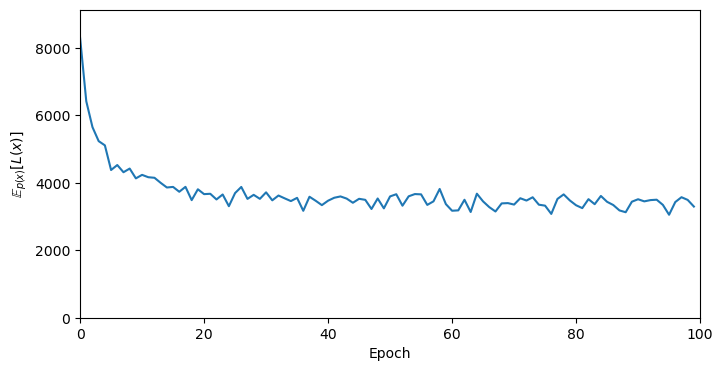

In [8]:
# Plot losses
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(losses)

_ = ax.set_xlabel("Epoch")
_ = ax.set_ylabel(r"$\mathbb{E}_{p(x)}[L(x)]$")  # Not actually the expectation because summing loss in each epoch
_ = ax.set_xlim(0, losses.shape[0])
_ = ax.set_ylim(0, 1.1 * jnp.max(losses))

In [9]:
loss, grads = jax.value_and_grad(las.loss)(params, model, corrupted_references[1, :], sigma_1, key=jr.PRNGKey(0))

In [10]:
# Test if parameters have nan
nan_tree = tu.tree_map(lambda x: jnp.any(jnp.isnan(x)), params)
nandemic = tu.tree_reduce(lambda x, y: x or y, nan_tree)
print(nandemic)

False


In [11]:
x_hat, mu_timeline = las.sample(params, model, sigma_1, 600, key=jr.PRNGKey(1))

In [12]:
mu_timeline

Array([[ 0.02440995, -0.06305403,  0.05883901,  0.03802557,  0.24080539],
       [-0.18727306, -0.04053831,  0.17625488,  0.10494402,  0.29013267],
       [-0.1979262 ,  0.116202  ,  0.02692216,  0.18590347,  0.21565293],
       ...,
       [ 0.17112818,  0.39800614,  0.57661414,  0.7725196 ,  1.0052186 ],
       [ 0.16834725,  0.3988258 ,  0.57733727,  0.77288675,  1.0032173 ],
       [ 0.16495544,  0.39784038,  0.5794045 ,  0.7697666 ,  1.006107  ]],      dtype=float32)

In [13]:
x_hat

Array([0.17790665, 0.39586294, 0.58582246, 0.778238  , 1.        ],      dtype=float32)